GradCam Analysis

Note: Reused code from https://towardsdatascience.com/grad-cam-in-pytorch-use-of-forward-and-backward-hooks-7eba5e38d569

In [3]:
import os
import sys
sys.path.append("/Users/edmundyoung/Desktop/Princeton/Courses/S23/COS429/FinalProject/COS429_FINAL")
sys.path.append("/Users/edmundyoung/Desktop/Princeton/Courses/S23/COS429/FinalProject/COS429_FINAL/models")
sys.path.append("/Users/edmundyoung/Desktop/Princeton/Courses/S23/COS429/FinalProject/COS429_FINAL/data")
import matplotlib.pyplot as plt
import numpy as np
import torch

from models import CNNClassifier, CNNEncoderV1, Classifier
from data_utils import get_loaders, get_svhn_data_loaders, get_mnist_data_loaders, get_usps_data_loaders

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def load_model(encoder_path, classifier_path):
   model = CNNClassifier()
   encoder = CNNEncoderV1()
   classifier = Classifier()

   encoder.load_state_dict(torch.load(encoder_path, map_location=torch.device('cpu')))
   classifier.load_state_dict(torch.load(classifier_path, map_location=torch.device('cpu')))
  
   model.encoder = encoder

   return model

In [11]:
path_prefix = "/Users/edmundyoung/Desktop/Princeton/Courses/S23/COS429/FinalProject/COS429_FINAL"

models = {}
models["mnist_svhn"] = load_model(prefix + "/weights/MNIST_on_SVHN_encoder.pt", prefix + "/weights/1/categorizer_{'mnist'}.pt")
models["mnist_usps"] = load_model(prefix + "/weights/MNIST_on_USPS_encoder.pt", prefix + "/weights/1/categorizer_{'mnist'}.pt")
models["svhn_mnist"] = load_model(prefix + "/weights/SVHN_on_MNIST_encoder.pt", prefix + "/weights/3/categorizer_{'svhn'}.pt")
models["svhn_usps"] = load_model(prefix + "/weights/SVHN_on_USPS_encoder.pt", prefix + "/weights/3/categorizer_{'svhn'}.pt")
models["usps_mnist"] = load_model(prefix + "/weights/USPS_on_MNIST_encoder.pt", prefix + "/weights/2/categorizer_{'usps'}.pt")
models["usps_svhn"] = load_model(prefix + "/weights/USPS_on_SVHN_encoder.pt", prefix + "/weights/2/categorizer_{'usps'}.pt")

# put it in evaluation mode for inference
for i in models.values():
    i.eval()
    print(i)

CNNClassifier(
  (encoder): CNNEncoderV1(
    (conv1): Sequential(
      (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
      (1): Dropout2d(p=0.5, inplace=False)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
    (linearize): Linear(in_features=800, out_features=500, bias=True)
  )
  (classifier): Classifier(
    (hidden): Linear(in_features=500, out_features=10, bias=True)
  )
)
CNNClassifier(
  (encoder): CNNEncoderV1(
    (conv1): Sequential(
      (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool2d(kernel_size=2, strid

In [31]:
layer = models["mnist_svhn"].encoder

In [32]:
# defines two global scope variables to store our gradients and activations
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Gradients size: {gradients[0].size()}') 
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Activations size: {activations.size()}')

In [33]:
backward_hook = layer.register_full_backward_hook(backward_hook)
forward_hook = layer.register_forward_hook(forward_hook)

In [34]:
# Load images
svhn = get_svhn_data_loaders()
mnist = get_mnist_data_loaders()
usps = get_usps_data_loaders()

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Text(0.5, 1.0, 'Label: 1')

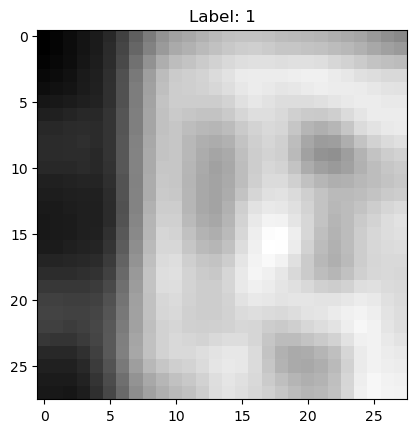

In [35]:
train_data_iterator = iter(svhn['train'])
images, label = train_data_iterator.__next__()

image = images[0]
# display the image
fig, ax = plt.subplots()
ax.imshow(image[0], cmap='gray')
ax.set_title('Label: {}'.format(label[0]))

In [37]:
models["mnist_svhn"](image.unsqueeze(0)).backward()

RuntimeError: grad can be implicitly created only for scalar outputs

AttributeError: 'CNNClassifier' object has no attribute 'inputs'